___
# <center> Import Python Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt

pd.set_option('display.max_columns',200)
pd.set_option('display.max_rows',200)
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"

___
## <center> Reading in our Saved CSV File
    
___

In [2]:
final_df = pd.read_csv('ModellingNewCarSales_Web.csv')
final_df.head(2)

,Price,Age,Engine_Durability,Model_Honda/Volvo/Ford,Model_Isuzu/MG,Model_Jeep/Skoda,Model_Kia/Audi/Maz/Mini/Suz/Land/VW,Model_LDV/GWM,Model_Lexus/BMW,Model_Mit/Hyun/Benz/Ren/Nis/Sub/Toy,Body_Coupe/Convertible,Body_Hatchback,Body_Sedan,Body_Wagon,Transmission_Manual,Drive_AWD,Drive_Rear,Fuel_type_Hybrid,Fuel_type_LPG,Fuel_type_Unleaded
0,15500.0,6,100.82,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1
1,6499.0,17,182.25,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1


___
## <center> ANN Model
    
___

In [15]:
from sklearn.neural_network import MLPRegressor

steps =[('scaler', StandardScaler()),
       ('mlp', MLPRegressor( max_iter = 300,
                            learning_rate_init = 0.2))]

ANN_pipeline = Pipeline(steps)


___
## <center> Splitting the dataset into training and validation
    
___

In [3]:
# Create X,y variables
X = final_df.drop(['Price'],axis =1).values
y = final_df['Price'].values

# Split Data into Training and Testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=77)
print('Training dataset: X_train=', X_train.shape, ', y_train', y_train.shape)
print('\nTesting dataset: X_test=', X_test.shape, ', y_test', y_test.shape)

Training dataset: X_train= (8431, 19) , y_train (8431,)

Testing dataset: X_test= (2811, 19) , y_test (2811,)


___
## <center> Hyper-Parameter Tunning
___

In [17]:
from sklearn.model_selection import RandomizedSearchCV,KFold

cv_inner = KFold(n_splits=5, shuffle=True, random_state=1)

#Calibration of the parameters
param_grid = {
    'mlp__hidden_layer_sizes': [(50,50,50), (50,100,50), (100,1)],
    'mlp__activation': ['relu','tanh'],
    'mlp__max_iter':[100,200],
    'mlp__alpha': [0.0001, 0.05],
    'mlp__learning_rate_init': [0.17,0.19],
    'mlp__solver': ['adam']
}

#Searching for the optimal from param_grid
grid_mse = RandomizedSearchCV(estimator= ANN_pipeline,
                                     param_distributions=param_grid,
                                     scoring='neg_mean_squared_error', 
                                     n_jobs = -1,
                                     cv=cv_inner, 
                                     verbose=1)# cv determines the cross-validation splitting


#Checking how many time takes to find the optimum values 
grid_mse.fit(X_train, y_train)
print('best parameters',grid_mse.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   28.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   43.6s finished


best parameters {'mlp__solver': 'adam', 'mlp__max_iter': 200, 'mlp__learning_rate_init': 0.19, 'mlp__hidden_layer_sizes': (50, 50, 50), 'mlp__alpha': 0.05, 'mlp__activation': 'relu'}


___
## <center> Model Performance – Evaluation
___

In [16]:
# Fit pipeline
ANN_pipeline.fit(X_train,y_train)

# Establishing a baseline
baseline = np.mean(y)
y_baseline = np.repeat(baseline, len(y_test))

# Establishing baseline root/mean-squared-error
naive_MSE = mean_squared_error(y_test, y_baseline)
naive_RMSE = np.sqrt(mean_squared_error(y_test, y_baseline))

# Prediction in the training dataset
y_train_pred = ANN_pipeline.predict(X_train)

# Prediction in the testing dataset 
y_test_pred = ANN_pipeline.predict(X_test)

# Establishing model mean-squared-error
MSE_training = mean_squared_error(y_train, y_train_pred)
MSE_test = mean_squared_error(y_test, y_test_pred)

# Establishing model root-mean-squared-error
RMSE_training = np.sqrt(mean_squared_error(y_train, y_train_pred))
RMSE_test=np.sqrt(mean_squared_error(y_test, y_test_pred))


print('The naive MSE baseline is ', naive_MSE)
print('The naive RMSE baseline is ', naive_RMSE)
print(f'\nThe model performance in training for MSE: {MSE_training}')
print(f'The model performance in training for RMSE: {RMSE_training}')
print(f'\nThe model performance in testing for MSE: {MSE_test}')
print(f'The model performance in testing for RMSE: {RMSE_test}')

The naive MSE baseline is  86737755.56235546
The naive RMSE baseline is  9313.31066604972

The model performance in training for MSE: 15398009.157728743
The model performance in training for RMSE: 3924.029709078251

The model performance in testing for MSE: 16445418.667606713
The model performance in testing for RMSE: 4055.29513939574


___
## <center> Tunned Model Performance – Evaluation
___

In [18]:
# Establishing a baseline
baseline = np.mean(y)
y_baseline = np.repeat(baseline, len(y_test))

# Establishing baseline root/mean-squared-error
naive_MSE = mean_squared_error(y_test, y_baseline)
naive_RMSE = np.sqrt(mean_squared_error(y_test, y_baseline))

# Prediction in the training dataset
y_train_pred = grid_mse.predict(X_train)

# Prediction in the testing dataset 
y_test_pred = grid_mse.predict(X_test)

# Establishing model mean-squared-error
MSE_training = mean_squared_error(y_train, y_train_pred)
MSE_test = mean_squared_error(y_test, y_test_pred)

# Establishing model root-mean-squared-error
RMSE_training = np.sqrt(mean_squared_error(y_train, y_train_pred))
RMSE_test=np.sqrt(mean_squared_error(y_test, y_test_pred))


print('The naive MSE baseline is ', naive_MSE)
print('The naive RMSE baseline is ', naive_RMSE)
print(f'\nThe model performance in training for MSE: {MSE_training}')
print(f'The model performance in training for RMSE: {RMSE_training}')
print(f'\nThe model performance in testing for MSE: {MSE_test}')
print(f'The model performance in testing for RMSE: {RMSE_test}')

The naive MSE baseline is  86737755.56235546
The naive RMSE baseline is  9313.31066604972

The model performance in training for MSE: 14231121.249730999
The model performance in training for RMSE: 3772.4158373290447

The model performance in testing for MSE: 16230784.539543003
The model performance in testing for RMSE: 4028.7447846125724


___
## <center> Model Performance – Plotting
___

<AxesSubplot:xlabel='true', ylabel='predicted'>

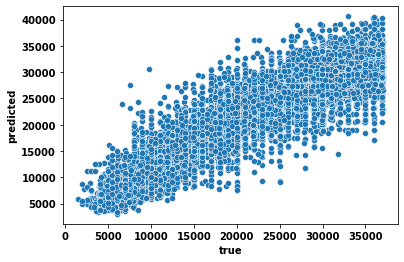

In [129]:
plotting_df = pd.DataFrame()
plotting_df['predicted'] = ANN_pipeline.predict(X)
plotting_df['true'] = y
sns.scatterplot(x = 'true', y = 'predicted', data = plotting_df)